In [1]:
# Mass ratio of all mergers (Historam, against redshift?)

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/e/jb2854/Mergers_Project')
from illustris_python import illustris_python as il

basePath = '/x/Physics/AstroPhysics/Shared-New/DATA/IllustrisTNG/TNG100-1/output'

In [71]:
def mergerInfo(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Based off numMergers function to identify the mergers, this function returns the two progenitor masses (default stellar) and the snapshot in which merging occured"""
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType','SnapNum']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    numMergers   = 0
    mergerProgenitors = []
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMass  = il.sublink.maxPastMass(tree, fpIndex, massPartType)

        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = il.sublink.maxPastMass(tree, npIndex, massPartType)

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 0.0 and npMass > 0.0:
                ratio = npMass / fpMass

                if ratio >= minMassRatio and ratio <= invMassRatio:
                    numMergers += 1
                    mergerProgenitors.append([fpMass, npMass, ratio, tree['SnapNum'][fpIndex]])

            npID = tree['NextProgenitorID'][npIndex]

        fpID = tree['FirstProgenitorID'][fpIndex]

    return mergerProgenitors

In [158]:
ratio = 1.0/20.0

# the following fields are required for the walk and the mass ratio analysis
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType','SnapNum']

ratios = []
start = 0
groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

# Function to find the mass ratios of all mergers in the tree of a given set of SubHaloIds at z=0
def findRatios(start, end, step):
    ratios = np.zeros([0,2])
    groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub']) # Load subhalos at z=0
    for i in range(start, start + (end-start), step):
        tree = il.sublink.loadTree(basePath,99,groupFirstSub[i],fields=fields) # Load tree for specific sub halo
        mergerInfo2 = mergerInfo(tree,minMassRatio=ratio) # Extract merger info from tree
        for i in range(len(mergerInfo2)):
            if (mergerInfo2[i][2] > 1):
                mergerInfo2[i][2] = 1/mergerInfo2[i][2] # Inverse ratio if > 1
            ratios = np.vstack((ratios, np.array([mergerInfo2[i][2],mergerInfo2[i][3]])))
    return ratios
    

In [166]:
ratios_massive = findRatios(0,2000,1)
ratios_small = findRatios(5000000,5002000,1)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
   

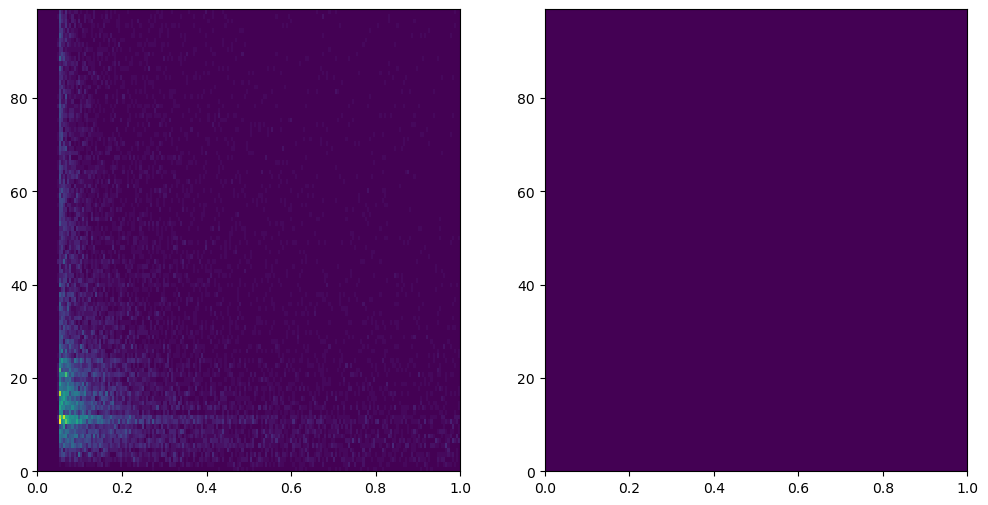

In [168]:
fig = plt.figure(figsize=(12,6))
axs = fig.subplots(nrows=1, ncols=2)
axs[0].hist2d(ratios_massive[:,0], ratios_massive[:,1], [np.linspace(0, 1, num=200), np.linspace(0, 99, num=99)])
axs[1].hist2d(ratios_small[:,0], ratios_small[:,1] ,[np.linspace(0, 1, num=200), np.linspace(0, 99, num=99)])

In [181]:
mergerstats = np.zeros([99,2])
for i in range(100):
    for j in range (len(ratios_massive[:,0])):
        if (ratios_massive[j,1] == i):
            mergerstats[i,0] += 1
            mergerstats[i,1] += ratios_massive[j,0]

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of mergers')

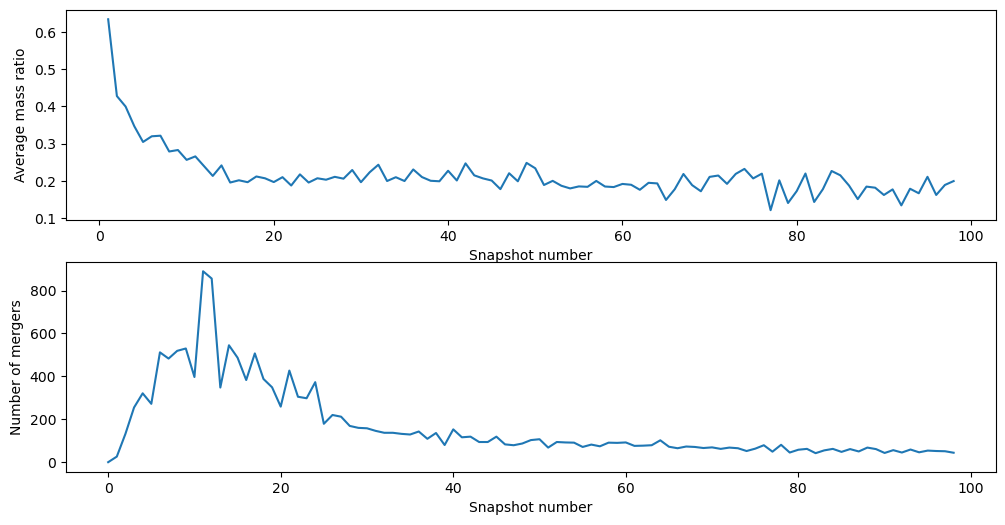

In [189]:
fig = plt.figure(figsize=(12,6))
axs = fig.subplots(nrows=2, ncols=1)
axs[0].plot(np.linspace(0,98,99), mergerstats[:, 1]/ mergerstats[:, 0])
axs[1].plot(np.linspace(0,98,99), mergerstats[:, 0])

axs[0].set_xlabel('Snapshot number')
axs[0].set_ylabel('Average mass ratio')
axs[1].set_xlabel('Snapshot number')
axs[1].set_ylabel('Number of mergers')